https://minpy.readthedocs.io/en/latest/tutorial/rnn_tutorial/rnn_tutorial.html

In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
import matplotlib.pyplot as plt

In [4]:
import numpy as np

In [5]:
def adding_problem_generator(N, seq_len=6, high=1):
    # input --> label
    # 1 2 1 5 6  ---> 8 (2+6)
    # 0 1 0 0 1
    X_num = np.random.uniform(high=high, size=(N, seq_len, 1))
    X_mask = np.zeros(shape=(N, seq_len, 1))
    Y = np.zeros(shape=(N,1))
    for i in range(N):
        # choose 2 random positions to be set to 1
        positions = np.random.choice(seq_len, size=2, replace=False)
        X_mask[i, positions] = 1
        Y[i, 0] = np.sum(X_num[i, positions])
    return np.concatenate((X_num, X_mask), axis=2), Y

In [6]:
N = 10000
T = 20
X_train, Y_train = adding_problem_generator(N, seq_len=T)

In [7]:
X_test, Y_test = adding_problem_generator(100, seq_len=T)

In [8]:
X_train[:1]

array([[[0.00896595, 0.        ],
        [0.8597838 , 0.        ],
        [0.57431011, 0.        ],
        [0.36871052, 0.        ],
        [0.16925328, 0.        ],
        [0.36403277, 0.        ],
        [0.80133993, 0.        ],
        [0.44525398, 0.        ],
        [0.40381705, 0.        ],
        [0.48552531, 0.        ],
        [0.46509252, 0.        ],
        [0.84062263, 0.        ],
        [0.13746974, 0.        ],
        [0.09630613, 0.        ],
        [0.43591491, 1.        ],
        [0.24794006, 0.        ],
        [0.31933798, 0.        ],
        [0.13483813, 0.        ],
        [0.61981373, 1.        ],
        [0.91275822, 0.        ]]])

In [9]:
Y_train[:1]

array([[1.05572864]])

In [10]:
X_test, Y_test = adding_problem_generator(N=10000, seq_len=T)

In [11]:
# baseline: always predict 1
baseline_mse = np.mean((Y_train-1)**2)

In [12]:
baseline_mse

0.16608767702310515

In [13]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import optim

# Elman RNN

In [14]:
class ElmanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, 
                          num_layers=1, 
                          nonlinearity='relu',
                          batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        
    
    def forward(self, inputs, hidden=None):
        outputs, hidden = self.rnn(inputs, hidden)
        #print(f"RNN: {outputs.shape}, {hidden.shape}")
        #print(f"squeeze: {hidden.squeeze(0).shape}")
        output = self.linear(hidden.squeeze(0))
        #print(f"output: {output.shape}")
        return output
    

In [15]:
X_train_T = torch.from_numpy(X_train).float()
Y_train_T = torch.from_numpy(Y_train).float()
X_test_T = torch.from_numpy(X_test).float()
Y_test_T = torch.from_numpy(Y_test).float()

In [16]:
X_train_T.shape

torch.Size([10000, 20, 2])

In [17]:
%%time
model = ElmanRNN(input_size=2, hidden_size=100, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

batch_size = 100
data_len = X_train.shape[0]
n_epochs = 50
losses = np.zeros(n_epochs)

for epoch in range(n_epochs):
    for start, end in zip(range(0, data_len+1, batch_size), 
                      range(batch_size, data_len+1, batch_size)):
        output = model(X_train_T[start:end]) # hidden is None

        optimizer.zero_grad()
        loss = criterion(output, Y_train_T[start:end])
        loss.backward()
        optimizer.step()
        
        losses[epoch] += loss.item()
        
    print("Epoch = {}, Loss = {}".format(epoch, losses[epoch]))

Epoch = 0, Loss = 30.468380391597748
Epoch = 1, Loss = 16.1964333280921
Epoch = 2, Loss = 15.616586424410343
Epoch = 3, Loss = 9.930038766935468
Epoch = 4, Loss = 1.7709462000057101
Epoch = 5, Loss = 0.7070015799254179
Epoch = 6, Loss = 0.41805045667570084
Epoch = 7, Loss = 0.2878923456883058
Epoch = 8, Loss = 0.20083657401846722
Epoch = 9, Loss = 0.15433746052440256
Epoch = 10, Loss = 0.11654785502469167
Epoch = 11, Loss = 0.08669210207881406
Epoch = 12, Loss = 0.06635035760700703
Epoch = 13, Loss = 0.06142119361902587
Epoch = 14, Loss = 0.05955263591022231
Epoch = 15, Loss = 0.05689646885730326
Epoch = 16, Loss = 0.05826521797280293
Epoch = 17, Loss = 0.06276010841247626
Epoch = 18, Loss = 0.060734252707334235
Epoch = 19, Loss = 0.05537802695471328
Epoch = 20, Loss = 0.04663849563803524
Epoch = 21, Loss = 0.04561456004012143
Epoch = 22, Loss = 0.04282862234686036
Epoch = 23, Loss = 0.037249285203870386
Epoch = 24, Loss = 0.05220875939994585
Epoch = 25, Loss = 0.04286489330843324
Epoc

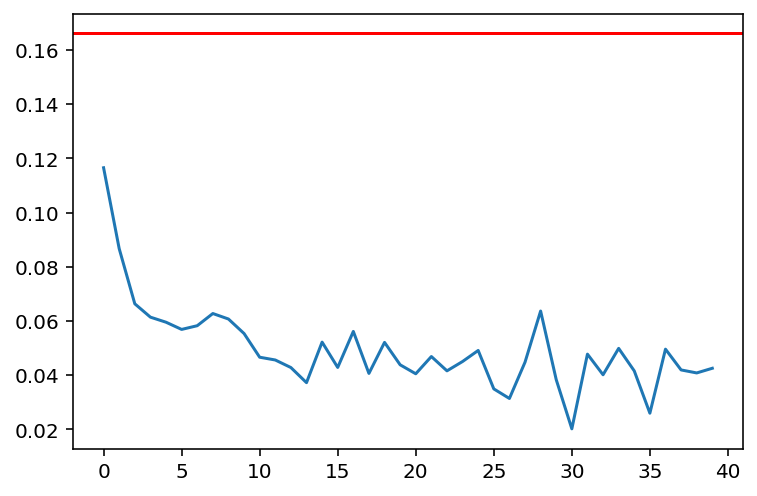

In [18]:
plt.plot(losses[10:])
plt.axhline(baseline_mse,color='r')

In [19]:
t = X_test_T[1:2,:,:]
t

tensor([[[0.7650, 1.0000],
         [0.8052, 0.0000],
         [0.5122, 0.0000],
         [0.9350, 0.0000],
         [0.8481, 0.0000],
         [0.1240, 0.0000],
         [0.8734, 0.0000],
         [0.7090, 0.0000],
         [0.1026, 0.0000],
         [0.3617, 0.0000],
         [0.5769, 0.0000],
         [0.8501, 0.0000],
         [0.4216, 0.0000],
         [0.9936, 0.0000],
         [0.2824, 0.0000],
         [0.5937, 0.0000],
         [0.6954, 0.0000],
         [0.9718, 0.0000],
         [0.7712, 1.0000],
         [0.8694, 0.0000]]])

In [20]:
model(t)

tensor([[1.5469]], grad_fn=<AddmmBackward>)

In [27]:
t[t[:,:,1]==1].sum(axis=0)

tensor([1.5361, 2.0000])